# Plotting DVL and Slocum Glider Data with Pandas & Seaborn

---
## Import Libraries

In [1]:
import datetime
import earthpy as et
import earthpy.plot as ep
import importlib
import numpy as np
import os
import pandas as pd
import rasterio as rio
import scipy
import seaborn as sns 
import struct
import sys
import utm
import unittest
from PIL import Image
from matplotlib import pyplot as plt 
from os import listdir
from os.path import isfile, join

# add parent directory to the path for importing modules 
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import PathfinderDVL
import PathfinderEnsemble
import PathfinderTimeSeries
import PathfinderUtils
import SlocumFlightController
import SlocumScienceController
import dvl_plotter
sns.set()

def reload_modules():
    importlib.reload(PathfinderDVL)
    importlib.reload(PathfinderEnsemble)
    importlib.reload(PathfinderTimeSeries)
    importlib.reload(PathfinderUtils)
    importlib.reload(SlocumFlightController)
    importlib.reload(SlocumScienceController)
    importlib.reload(dvl_plotter)

---
## 1. Load or Parse DVL data 

In [2]:
reload_modules()
glider = "sentinel"
filepath = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/pd0-raw/%s/" % (glider)
# plotting 
filename = "sk261222.pd0" # DIVE A --  example of another cool mission (less bottom track, long dive)
# filename = "01820002.pd0" # DIVE B -- example of prime data set to work with
# filename = "sk220034.pd0" # DIVE C
# filename = "01820008.pd0" # DIVE D
# filename = "01820013.pd0" # DIVE E
# filename = "sk222256.pd0" # DIVE F
ts = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename, save=False)

________________________________________
- Parsing DVL File ---------------------
    input file: sk261222.pd0
    # ensembles:    200
    # ensembles:    400
    # ensembles:    600
    # ensembles:    800
    # ensembles:   1000
    # ensembles:   1200
    # ensembles:   1400
    # ensembles:   1600
    # ensembles:   1800
    # ensembles:   2000
    # ensembles:   2200
    # ensembles:   2400
    # ensembles:   2600
- Parsing Complete ---------------------
    # ensembles:   2794
    parsing time:  8.351128
- Sensor Configuration -----------------
    600kHz System
    Convex Beam Pattern
    Sensor Config #1
    Attached
    Down Facing
    30E Beam Angle
    4 Beam Janus
- Coordinate Transformation ------------
    Bin Mapping Used
    3-Beam Soln Used
    Tilts Used
    Earth Coords


---
## 2. Determine Water Column Currents from DVL data 

In [49]:
reload_modules()

# tuning parameters for working with DVL data 
pitch_bias           =  8    # mounting pitch bias for the sonar, effects bin length in the vertical
start_filter         =  2    # avoid using the first number of bins in velocity estimate
end_filter           =  2    # avoid using the last number of bins in velocity estimate
voc_mag_filter       =  0.5  # filter out ocean current estimates larger than this 
voc_delta_mag_filter =  0.3  # filter out deltas between layers that are larger than this value


# determine DVL parameters 
bin_len      = ts.df.depth_bin_length[0]
bin0_dist    = ts.df.bin0_distance[0]
bin_len      = np.cos(pitch_bias*np.pi/180)*bin_len
bin0_dist    = np.cos(pitch_bias*np.pi/180)*bin0_dist
max_range    = 80
max_depth    = int(np.max(ts.df.depth)+80)
x_beam       = 0
y_beam       = 1
z_beam       = 2

# used for potentially skipping beginning of file
start_skip   = 80
look_len     = 500

# intialize water column
water_column = PathfinderUtils.WaterColumn(
    bin_len=bin_len, 
    bin0_dist=bin0_dist,
    max_depth=max_depth,
    start_filter=start_filter,
    end_filter=end_filter,
    voc_mag_filter=voc_mag_filter,
    voc_delta_mag_filter=voc_delta_mag_filter,
)

# iterate over the DVL ensembles 
for t in range(len(ts.df)):

    # take difference between dead-reckoned velocity and DVL velocity 
    num_good_vel_bins = ts.df.num_good_vel_bins[t]
    
    if not np.isnan(ts.df.abs_vel_btm_u[t]):
        vog_x = ts.df.abs_vel_btm_u[t]
        vog_y = ts.df.abs_vel_btm_v[t]
        vtw_x = ts.df.rel_vel_dvl_u[t]
        vtw_y = ts.df.rel_vel_dvl_v[t]
        voc_x = vog_x - vtw_x
        voc_y = vog_y - vtw_y
        voc_ref = PathfinderUtils.OceanCurrent(voc_x, voc_y, 0)
    else:
        voc_ref = PathfinderUtils.OceanCurrent()
        
    if num_good_vel_bins > start_filter+end_filter:
        DR_x    = ts.df.rel_vel_pressure_u[t]
        DR_y    = ts.df.rel_vel_pressure_v[t]
        depth   = ts.df.depth[t]
        delta_z = ts.df.delta_z[t]
        delta_oc_x = []
        delta_oc_y = []
        if delta_z > 0:
            direction = 'descending'
        else:
            direction = 'ascending'

        if not (np.isnan(DR_x)):

            # skip the first two bins because they have spurious readings
            for bin_num in range(int(num_good_vel_bins)):

                # retrieve the shear list from the DVL data 
                x_var = ts.get_profile_var_name('velocity', bin_num, x_beam)
                y_var = ts.get_profile_var_name('velocity', bin_num, y_beam)
                z_var = ts.get_profile_var_name('velocity', bin_num, z_beam)
                dvl_x = ts.df[x_var][t]
                dvl_y = ts.df[y_var][t]
                dvl_z = ts.df[z_var][t]
                delta_oc_x.append(DR_x - (-dvl_x))
                delta_oc_y.append(DR_y - (-dvl_y))

        shear_list = [PathfinderUtils.OceanCurrent(delta_oc_x[i], delta_oc_y[i], 0) for i in range(len(delta_oc_x))]

        # add shear node to the water column with shear list information 
        if len(shear_list):
            water_column.add_shear_node(
                z_true=depth,
                t=t,
                shear_list=shear_list,
                voc_ref=voc_ref,
                direction=direction
            )

    # add voc_ref measurement to the water column even if shear list is empty  
    elif not voc_ref.is_none():
        water_column.add_shear_node(
            z_true=depth,
            t=t,
            shear_list=[],
            voc_ref=voc_ref,
            direction=direction
        )
        
voc_u_list,voc_v_list,voc_w_list,voc_z_list = water_column.compute_averages()
print(water_column.averages_to_str())
print("> Finsished Computing Water Column Currents!")

Water Column (depth=494) 
|z =  0| V[  26,  -7,   0]
|z =  1| V[----,----,----]
|z =  2| V[----,----,----]
|z =  3| V[----,----,----]
|z =  4| V[----,----,----]
|z =  5| V[----,----,----]
|z =  6| V[  27, -18,   0]
|z =  7| V[----,----,----]
|z =  8| V[  27, -18,   0]
|z =  9| V[  32, -25,   0]
|z = 10| V[  27, -18,   0]
|z = 11| V[  33, -23,   0]
|z = 12| V[  27, -18,   0]
|z = 13| V[  33, -24,   0]
|z = 14| V[  25, -17,   0]
|z = 15| V[  10, -19,   0]
|z = 16| V[----,----,----]
|z = 17| V[ -13, -21,   0]
|z = 18| V[----,----,----]
|z = 19| V[ -15, -19,   0]
|z = 20| V[  23, -22,   0]
|z = 21| V[   6,   0,   0]
|z = 22| V[   9, -17,   0]
|z = 23| V[----,----,----]
|z = 24| V[  12, -11,   0]
|z = 25| V[  18, -42,   0]
|z = 26| V[   4, -11,   0]
|z = 27| V[  18, -35,   0]
|z = 28| V[   9,  -6,   0]
|z = 29| V[----,----,----]
|z = 30| V[  11,   3,   0]
|z = 31| V[  21,  -4,   0]
|z = 32| V[  14,   2,   0]
|z = 33| V[  16, -12,   0]
|z = 34| V[  15,  -2,   0]
|z = 35| V[  13, -14,   0]
|z

---
## 3. Use Water Column Currents to Improve Odometry

In [50]:
roll_size = 1

# through-water velocity given by dead-reckoned algorithm
roll_vtw_u = ts.df.rel_vel_pressure_u.rolling(roll_size).median()
roll_vtw_v = ts.df.rel_vel_pressure_v.rolling(roll_size).median()

# move position columns around 
ts.df['rel_pos_x_dvl_dr'] = ts.df['rel_pos_x'].copy()
ts.df['rel_pos_y_dvl_dr'] = ts.df['rel_pos_y'].copy()
ts.df['rel_pos_z_dvl_dr'] = ts.df['rel_pos_z'].copy()

# initialize list for new odometry
rel_pos_x = [0]
rel_pos_y = [0]
rel_pos_z = [0]

# iterate through the dive file to update odometry
for t in range(1,len(ts.df)):
    prev_x = rel_pos_x[-1]
    prev_y = rel_pos_y[-1]
    delta_t = ts.df.delta_t[t]
    z = ts.df.depth[t]
    vtw_u = roll_vtw_u[t]
    vtw_v = roll_vtw_v[t]
    voc_u = voc_u_list[int(z)]
    voc_v = voc_v_list[int(z)]
    
    # four cases for determining change in position for x and y
    if np.isnan(vtw_u):
        if np.isnan(voc_u):
            delta_x = 0
            delta_y = 0
        else: 
            delta_x = voc_u*delta_t
            delta_y = voc_v*delta_t
    else:
        if np.isnan(voc_u):
            delta_x = vtw_u*delta_t
            delta_y = vtw_v*delta_t
        else:
            delta_x = (vtw_u + voc_u)*delta_t
            delta_y = (vtw_v + voc_v)*delta_t
    
    rel_pos_x.append(delta_x+prev_x)
    rel_pos_y.append(delta_y+prev_y)
    rel_pos_z.append(z)

# add new odomety to the data frame
ts.df['rel_pos_x'] = rel_pos_x
ts.df['rel_pos_y'] = rel_pos_y
ts.df['rel_pos_z'] = rel_pos_z

print("> Finished Calculating Odometry!")

> Finished Calculating Odometry!


---
## Plotting: Improved Odometry and Water Column Currents

### DVL Odometry

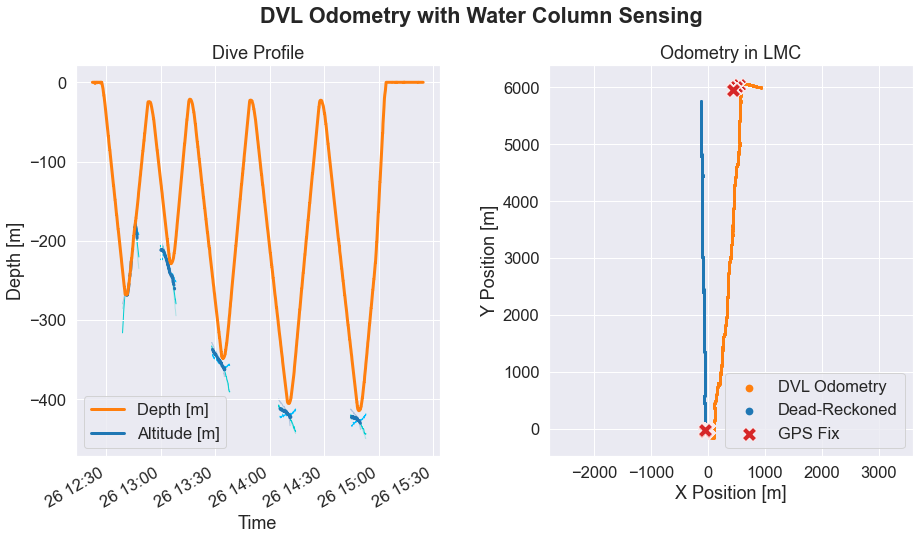

In [51]:
reload_modules()
dvl_plotter.plot_profile_and_odometry_and_dr(ts, ts_flight_kolumbo_all, glider='sentinel')
# dvl_plotter.plot_odometry(ts, glider='sentinel')

### Water Column Currents

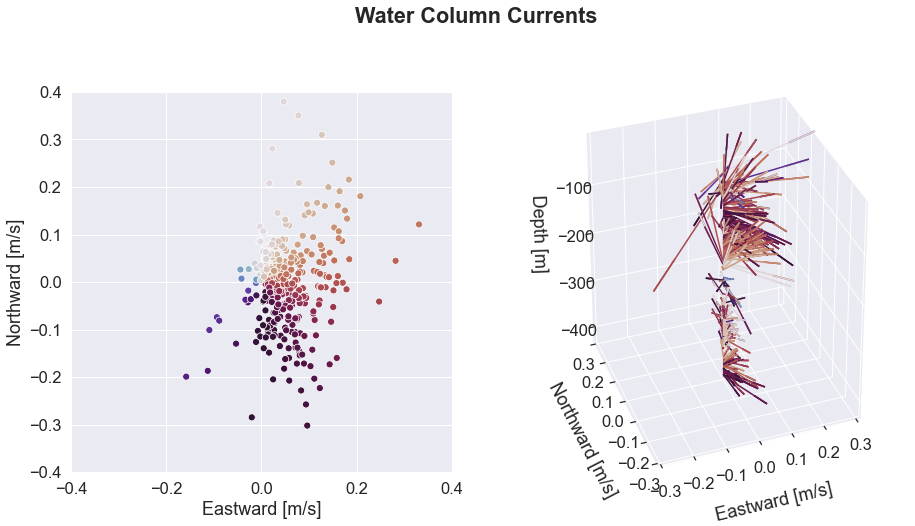

In [21]:
sns.set(font_scale = 1.5)
fig = plt.figure(figsize=(15,8),)

# plot ocean currents in u-v plane
ax = fig.add_subplot(1, 2, 1, aspect='equal')
c = np.arctan2(voc_u_list,voc_v_list)
sns.scatterplot(voc_u_list,voc_v_list,c,s=50,palette='twilight_shifted',legend=False)
plt.xlabel('Eastward [m/s]')
plt.ylabel('Northward [m/s]')
ax.set_xlim(-0.4,0.4)
ax.set_ylim(-0.4,0.4)

# plot 3D quiver plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

# voc_u,voc_v,voc_w,voc_z
u = voc_u_list[pd.notnull(voc_u_list)]
v = voc_v_list[pd.notnull(voc_u_list)]
w = voc_w_list[pd.notnull(voc_u_list)]
z = voc_z_list[pd.notnull(voc_u_list)]
x = np.zeros(u.shape)
y = np.zeros(u.shape)

c = (np.arctan2(u,v) + np.pi)/(2*np.pi)
c = np.concatenate((c, np.repeat(c, 2)))
c = plt.cm.twilight_shifted(c) 
# c = plt.cm.twilight(c) 
ax.quiver(x, y, -z, u, v, w, colors=c,length=1,normalize=False)
ax.patch.set_facecolor('white')
# plt.style.use('seaborn-darkgrid')
ax.w_xaxis.set_pane_color((234/255, 234/255, 242/255, 1.0))
ax.w_yaxis.set_pane_color((234/255, 234/255, 242/255, 1.0))
ax.w_zaxis.set_pane_color((234/255, 234/255, 242/255, 1.0))
ax.set_xlabel('\n\nEastward [m/s]')
ax.set_ylabel('\n\nNorthward [m/s]')
ax.set_zlabel('\n\nDepth [m]')
# ax.elev = 10000
ax.azim = -110
# ax.azim = -90
# ax.azim = -45
# ax.azim = 0

# ax.elev = 10
ax.elev = 30
# ax.elev = 1000
ax_max  = 0.3
plt.xlim(-ax_max,ax_max)
plt.ylim(-ax_max,ax_max)

unit_name = {"sentinel" : "Unit 250",
             "unit_770" : "Unit 770" }
dt = datetime.datetime.fromtimestamp(ts.df.time[0]).replace(microsecond=0)
plt.suptitle('Water Column Currents', fontweight='bold')
plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')
# plt.suptitle('%s Kolumbo Volcano %s' % (unit_name[glider], dt.isoformat(),), fontweight='bold')

---
## Adaptive Velocity Control

In [ ]:
DEG_TO_RAD       = np.pi/180
HOURS_TO_SECONDS = 60*60

def get_prop_power(v):
    '''Determines propulsive power needed to achieve through-water speed v, new model.
    '''
    vmin = 0.0
    vmax = 1.5
    v = max(min(v, vmax), vmin)
    c3 =  3.7856
    c2 =  1.9944
    c1 = -0.2221
    c0 =  1.0948
    return(c3*v**3 + c2*v**2 + c1*v + c0)


def get_opt_v(v_list, c, d, h, E, model_num=3):
    """Return optimal velocity from list of velocities given other operating conditions. 
    
    Args:
        v_list: list of possible velocity values to choose from 
        c: ocean current speed (magnitude)
        d: angle of ocean current relative to glider heading (heading of travel)
        h: hotel load of the vehicle 
        E: energy capacity of the vehicle (used for computing range)
        model_num: the glider efficiency model to use in the computation
    """
    r_list  = [get_range(g, c, d, h, E, model_num=model_num) for g in v_list]
    max_idx = np.nanargmax(r_list)
    max_r   = r_list[max_idx]
    opt_v   = v_list[max_idx]
    return(opt_v)


def get_range(v_g, v_c, delta, p_hotel, E, model_num=3):
    """Computes the range that can be achieved given the state variables.
    
    Args: 
        i: input current in [Amps]
        v_current: ocean current speed magnitude in [m/s]
        delta: angle between heading and v_current [rad]
        hotel: all non-propulsive power [Amps]
        E: total energy capacity [Amp-Hours]
        model_num: the glider efficiency model to use in the computation
    """
    v_c_para    =  v_c*np.cos(delta)
    v_c_perp    =  np.abs(v_c*np.sin(delta))
    
    # glider cannot overcome side-slipe ocean current 
    if v_g < v_c_perp:
        return(np.NaN)
    
    # glider cannot overcome adverse parallel currents
    v_para  = (v_g**2 - v_c_perp**2)**0.5
    if v_para < -v_c_para:
        return(np.NaN)
    
    # glider can succesfully move in intended direction
    # get propulsive power for given velocity using appropriate model
    v_total     = v_para + v_c_para
    p_prop      = get_prop_power(v_g)  
    t_total = (E*HOURS_TO_SECONDS)/(p_prop + p_hotel)
    return (v_total*t_total)

def get_objective(v_g, v_c, delta, p_hotel):
        """return objective function"""
        numerator   = (v_g**2 - (v_c*np.sin(delta))**2)**0.5 + v_c*np.cos(delta)
        denominator = (get_prop_power(v_g) + p_hotel)
        return(numerator/denominator)

In [ ]:
# compute the optimal and regular glider velocities given the water column velocities
survey_hotel  = 8.55
transit_hotel = 0.37
DVL_hotel     = 5.01
hotel         = 10
E = 3000
v_list = np.linspace(0.1,1.5,100)
reg_vg = get_opt_v(v_list, 0, 0, hotel, E)
max_vg = 1.5

opt_vg_mag   = [] 
reg_vg_mag   = []
max_vg_mag   = []
opt_vg_voc_u = []
opt_vg_voc_v = [] 
opt_vg_voc   = []
opt_E_usage  = []
reg_E_usage  = []
opt_dist_traveled = []
reg_dist_traveled = []

reg_obj = []
opt_obj = []
reg_obj_delta_x = []
reg_obj_delta_E = []
opt_obj_delta_x = []
opt_obj_delta_E = []

for t in range(len(ts.df)):
    z_true = ts.df.depth[t]
    z_bin  = int(z_true)
    opt_vg_voc_u.append(voc_u_list[z_bin])
    opt_vg_voc_v.append(voc_v_list[z_bin])
    mag_voc = np.linalg.norm([voc_u_list[z_bin], voc_v_list[z_bin]])
    ang_voc = np.arctan2(voc_u_list[z_bin], voc_v_list[z_bin])
    
    # only compute optimal velocity if ocean current available
    # otherwise use previous measurement for plot consistency
    if not np.isnan(mag_voc):
        opt_vg      = get_opt_v(v_list, mag_voc, ang_voc, hotel, E)
        cur_mag_voc = mag_voc
        cur_ang_voc = ang_voc

    opt_vg_voc.append(cur_mag_voc)
    opt_vg_mag.append(opt_vg)
    reg_vg_mag.append(reg_vg)
    max_vg_mag.append(max_vg)
    
    # get_objective(v_g, v_c, delta, p_hotel)
    o_obj = get_objective(opt_vg, cur_mag_voc, cur_ang_voc, hotel)
    r_obj = get_objective(reg_vg, cur_mag_voc, cur_ang_voc, hotel)
    o_pow = get_prop_power(opt_vg) + survey_hotel
    r_pow = get_prop_power(reg_vg) + survey_hotel
    o_dx  = o_obj*o_pow
    r_dx  = r_obj*r_pow
    
    # update the lists
    reg_obj.append(r_obj)
    opt_obj.append(o_obj)
    reg_obj_delta_x.append(r_dx)
    reg_obj_delta_E.append(r_pow)
    opt_obj_delta_x.append(o_dx)
    opt_obj_delta_E.append(o_pow)
    

sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(15,8))
roll_size    = 20
roll_voc_u   = list(pd.Series(opt_vg_voc_u).rolling(roll_size).median())
roll_voc_v   = list(pd.Series(opt_vg_voc_v).rolling(roll_size).median())
roll_voc_mag = list(pd.Series(opt_vg_voc).rolling(roll_size).median())
roll_vg_mag  = list(pd.Series(opt_vg_mag).rolling(roll_size).median())
roll_reg_obj = list(pd.Series(reg_obj).rolling(roll_size).median())
roll_opt_obj = list(pd.Series(opt_obj).rolling(roll_size).median())

improvement  = np.array(opt_obj) - np.array(reg_obj)
# print(sum(im))
# improvement  = list(pd.Series(improvement).rolling(1).median())

ts.df['roll_voc_mag'] = roll_voc_mag
ts.df['roll_vg_mag']  = roll_vg_mag
ts.df['reg_vg_mag']   = reg_vg_mag
ts.df['roll_reg_obj'] = roll_reg_obj
ts.df['roll_opt_obj'] = roll_opt_obj
ts.df['improvement']  = improvement

ts.df.roll_voc_mag.plot.line(lw=3, label=r"$|v_{oc}|$",          color = 'tab:blue')
ts.df.reg_vg_mag.plot.line(  lw=3, label=r"$|v'_{tw}|$",         color = 'tab:green')
ts.df.roll_vg_mag.plot.line( lw=3, label=r"$|v*_{tw}(v_{oc})|$", color = 'tab:orange')

# ts.df.roll_reg_obj.plot.line(label='bad')
# ts.df.improvement.plot.line(label='improvement')
# print(np.sum(improvement))

# sns.distplot(roll_v)
# sns.lineplot(ts.df.time, roll_voc_mag, lw=3, data=ts.df, label=r"$|v_{oc}|$", color = 'tab:blue')
# sns.lineplot(ts.df.time, reg_vg_mag,   lw=3, data=ts.df, label=r"$|v'_{tw}|$", color ='tab:green')
# sns.lineplot(ts.df.time, roll_vg_mag,  lw=3, data=ts.df, label=r"$|v*_{tw}(v_{oc})|$", color='tab:orange')
plt.legend(frameon=True)
plt.ylabel('Velocity Magnitude [m/s]')
plt.xlabel('Time')
plt.suptitle('Adaptive Velocity Control vs. Constant Velocity Control', fontweight='bold')
plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')
# sns.lineplot(ts.df.time, roll_v, lw=3, data=ts.df)
# sns.lineplot(ts.df.time, roll_v, data=ts.df)

In [ ]:
# reg_obj.append(r_obj)
# opt_obj.append(o_obj)
# reg_obj_delta_x.append(r_dx)
# reg_obj_delta_E.append(r_pow)
# opt_obj_delta_x.append(o_dx)
# opt_obj_delta_E.append(o_pow)

# sns.distplot(reg_obj_delta_E)
# sns.distplot(opt_obj_delta_E)
# pd.Series(np.array(opt_obj_delta_x) - np.array(reg_obj_delta_x)).cumsum().plot.line()
# pd.Series(np.array(opt_obj_delta_E) - np.array(reg_obj_delta_E)).cumsum().plot.line()
# pd.Series(opt_obj_delta_x).cumsum().plot.line()

# total_opt_dist = np.sum(opt_obj_delta_x)
# total_reg_dist = np.sum(reg_obj_delta_x)
# total_opt_ener = np.sum(opt_obj_delta_E)
# total_reg_ener = np.sum(reg_obj_delta_E)

# print(total_opt_dist)
# print(total_reg_dist)
# print()
# print(total_opt_ener)
# print(total_reg_ener)
# print()
# print(total_opt_dist/total_opt_ener)
# print(total_reg_dist/total_reg_ener)

# # sns.lineplot(ts.df.time, opt_obj_delta_E)
# # sns.lineplot(ts.df.time, reg_obj_delta_E)

# sns.lineplot(ts.df.time, opt_vg_mag)
# sns.lineplot(ts.df.time, reg_vg)




In [ ]:
improvement = np.array(opt_obj) - np.array(reg_obj)
improvement = list(pd.Series(improvement).rolling(roll_size).median())

In [ ]:
# # code for selecting portion of vehicle flight data that matches current file
# start  = datetime.datetime.fromtimestamp(ts.df.time[0])
# end    = datetime.datetime.fromtimestamp(ts.df.time[-1])
# dur    = end - start 
# df_dbd = ts_flight_kolumbo_all.df[str(start):str(end)].copy()

odo_x =  627.899965349145 
odo_y = 6082.9592204225855
dr_x  = -112.333
dr_y  = 5752.65
gps_x =  549.703
gps_y = 6038.14
last_time_before_gps = 1574798703.95676

dist_traveled  = np.linalg.norm([gps_x,         gps_y])
dist_error_dr  = np.linalg.norm([gps_x - dr_x,  gps_y - dr_y])
dist_error_odo = np.linalg.norm([gps_x - odo_x, gps_y - odo_y])

print(dist_traveled)
print(dist_error_dr,  (dist_error_dr/dist_traveled)*100)
print(dist_error_odo, (dist_error_odo/dist_traveled)*100)

# results from Dive A
# 6063.110426819638
#  720.9689351116318  11.891073794771886
#   90.13061582560978  1.486540892063006

---
## Load or Parse Slocum Glider data 

In [9]:
reload_modules()
directory = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/dbd-parsed/sentinel_2019-Nov/"
ts_flight_kolumbo_all = SlocumFlightController.SlocumFlightController.from_directory(directory, save=False, verbose=False)

>> Parsing folder of ASC Files
>> Finished Parsing!


In [ ]:
ts_flight_kolumbo_all.df

In [ ]:
ts_flight_kolumbo_all.df.to_csv("/Users/zduguid/Desktop/Kolumbo-glider-flight-computer.csv")

---
## Combine DVL data with Flight Controller and convert to UTM

In [ ]:
reload_modules()
SAVE = False
PLOT = True
glider      = "sentinel"
directory   = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/pd0-parsed/%s/" % glider
file_list   = [f for f in listdir(directory) if 
               isfile(join(directory,f)) and f.split('.')[-1] == 'CSV' and 
               len(f.split('_odometry')) != 2]

def get_utm_coords(m_lat, m_lon): 
    """TODO
    """
    SECS_IN_MIN = 60
    MIN_OFFSET = 100
    lat_min  = m_lat % MIN_OFFSET 
    lon_min  = m_lon % MIN_OFFSET 
    lat_dec  = (m_lat - lat_min)/MIN_OFFSET + lat_min/SECS_IN_MIN
    lon_dec  = (m_lon - lon_min)/MIN_OFFSET + lon_min/SECS_IN_MIN
    utm_pos  = utm.from_latlon(lat_dec, lon_dec)
    easting  = round(utm_pos[0],2)
    northing = round(utm_pos[1],2)
    zone     = utm_pos[2]
    return(easting, northing, zone)


# build dataframes for each odometry category 
dr_list  = []
odo_list = []
gps_list = []
wpt_list = []
all_list = []

# iterate through each dbd file and 
for f in file_list:
    SECS_IN_HOUR = 60*60
    SECS_IN_MIN  = 60
    df_pd0 = pd.read_csv(directory+f, header=0, index_col=0, parse_dates=True)
    start  = datetime.datetime.fromtimestamp(df_pd0.time[0])
    end    = datetime.datetime.fromtimestamp(df_pd0.time[-1])
    dur    = end - start 
    
    # sub-select a portion of glider flight computer variables
    df_dbd = ts_flight_kolumbo_all.df[str(start):str(end)].copy()
    print(f, "-------------------------")
    
    # extract first lat/lon gps position to use as origin
    for lat in df_dbd.m_gps_lat:
        if not np.isnan(lat):
            origin_m_lat = lat
            break
    origin_index = list(df_dbd.m_gps_lat).index(origin_m_lat)
    origin_m_lon = df_dbd.m_gps_lon[origin_index]
    origin_time  = datetime.datetime.fromtimestamp(df_dbd.time[origin_index])
    origin_hash  = df_dbd.m_filename_hash[origin_index]

    # convert to lat/lon coordinates to decimal fromat 
    origin_east,origin_north,origin_zone = get_utm_coords(origin_m_lat,origin_m_lon)
    
    # account for case when multiple dbd files span a single pd0 file
    print("    # dbd ensembles:  %d" % len(df_dbd))
    print("        # dbd files:  %d" % len(set(df_dbd.m_filename_hash)))
    print("         # missions:  %d" % len(set(df_dbd.m_mission_hash)))
    print("   input <lat, lon>: <%.2f, %.2f>" % (origin_m_lat, origin_m_lon))
    print("     UTM <  E,   N>: <%.2f, %.2f, zone=%d>\n\n" % (origin_east, origin_north, origin_zone))
    
    # extract positional offsets for the same moment in time
    sg2_x_offset = df_dbd[origin_time:].m_x_lmc[0]
    sg2_y_offset = df_dbd[origin_time:].m_y_lmc[0]
    dvl_x_offset = df_pd0[origin_time:].rel_pos_x[0]
    dvl_y_offset = df_pd0[origin_time:].rel_pos_y[0]

    # account for offsets in Glider and DVL file
    # TODO make this more SFB
    utm_dr_x  = df_dbd.m_x_lmc     - sg2_x_offset + origin_east
    utm_dr_y  = df_dbd.m_y_lmc     - sg2_y_offset + origin_north
    utm_dr_z  = df_dbd.m_depth 
    utm_gps_x = df_dbd.m_gps_x_lmc - sg2_x_offset + origin_east
    utm_gps_y = df_dbd.m_gps_y_lmc - sg2_y_offset + origin_north
    utm_wpt_x = df_dbd.c_wpt_x_lmc - sg2_x_offset + origin_east 
    utm_wpt_y = df_dbd.c_wpt_y_lmc - sg2_y_offset + origin_north 
    utm_odo_x = df_pd0.rel_pos_x   - dvl_x_offset + origin_east
    utm_odo_y = df_pd0.rel_pos_y   - dvl_y_offset + origin_north 
    utm_odo_z = df_pd0.rel_pos_z

    # collect data into indvidual DataFrames
    df_seg_dr = pd.DataFrame({
        'utm_dr_x' : utm_dr_x,
        'utm_dr_y' : utm_dr_y,
        'utm_dr_z' : utm_dr_z,
    })
    df_seg_gps = pd.DataFrame({
        'utm_gps_x' : utm_gps_x,
        'utm_gps_y' : utm_gps_y,
    })
    df_seg_odo = pd.DataFrame({
        'utm_odo_x' : utm_odo_x,
        'utm_odo_y' : utm_odo_y,
        'utm_odo_z' : utm_odo_z,
    })
    df_seg_wpt = pd.DataFrame({
        'utm_wpt_x' : utm_wpt_x,
        'utm_wpt_y' : utm_wpt_y,
    })
    
    # add dataframes to running list 
    dr_list.append(df_seg_dr)
    odo_list.append(df_seg_odo)
    gps_list.append(df_seg_gps)
    wpt_list.append(df_seg_wpt)

    # convert data to pandas DataFrame
    frames = {
        'utm_dr_x'  : utm_dr_x,
        'utm_dr_y'  : utm_dr_y,
        'utm_dr_z'  : utm_dr_z,
        'utm_gps_x' : utm_gps_x,
        'utm_gps_y' : utm_gps_y,
        'utm_wpt_x' : utm_wpt_x,
        'utm_wpt_y' : utm_wpt_y,
        'utm_odo_x' : utm_odo_x,
        'utm_odo_y' : utm_odo_y,
        'utm_odo_z' : utm_odo_z,    
    }
    df_all = pd.DataFrame(frames)
    all_list.append(df_all)
    
    # generate plots
    if PLOT:
        dvl_plotter.plot_odometry_and_dr_utm(df_all, glider, '/Users/zduguid/Desktop/fig/%s.png' % f.split('.')[0])
    if SAVE:
        df_odo.to_csv('/Users/zduguid/Desktop/fig/%s.csv' % f.split('.')[0])

In [ ]:
# # COMBINE FILES 
# df_dr_all  = pd.concat(dr_list)
# df_odo_all = pd.concat(odo_list)
# df_gps_all = pd.concat(gps_list)
# df_wpt_all = pd.concat(wpt_list)
# df_all_all = pd.concat(all_list)

# # PLOTTING
# sns.scatterplot(df_dr_all.utm_dr_x, df_dr_all.utm_dr_y)
# sns.scatterplot(df_wpt_all.utm_wpt_x, df_wpt_all.utm_wpt_y)
# sns.scatterplot(df_gps_all.utm_gps_x, df_gps_all.utm_gps_y)
# sns.scatterplot(df_odo_all.utm_odo_x, df_odo_all.utm_odo_y)

# # SAVING
# df_dr_all.to_csv('/Users/zduguid/Downloads/dr_all.csv')
# df_odo_all.to_csv('/Users/zduguid/Downloads/df_odo_all.csv')
# df_gps_all.to_csv('/Users/zduguid/Downloads/df_gps_all.csv')
# df_wpt_all.to_csv('/Users/zduguid/Downloads/df_wpt_all.csv')
# df_all_all.to_csv('/Users/zduguid/Downloads/all_fields_all_dives.csv')

---
## Plotting

In [ ]:
reload_modules()
glider = "sentinel"
dvl_plotter.plot_profile(ts, glider)

---
## Exploratory Plotting 

### Evaluating Ocean Current Deltas

In [ ]:
# filter out bin0, bin1 -- something fishy going on here
# pursue bin2+
pitch_bias = 12
bin_len = ts.df.depth_bin_length[0]
bin0_dist = ts.df.bin0_distance[0]

v_oc_abs_x = ts.df.abs_vel_btm_u - ts.df.rel_vel_dvl_u
v_oc_abs_y = ts.df.abs_vel_btm_v - ts.df.rel_vel_dvl_v

v_bin2_to_bin3_x = -ts.df.vel_bin2_beam0 + ts.df.vel_bin3_beam0
v_bin2_to_bin3_y = -ts.df.vel_bin2_beam1 + ts.df.vel_bin3_beam1

v_pres_to_bin2_x = ts.df.rel_vel_pressure_u + ts.df.vel_bin2_beam0
v_pres_to_bin2_y = ts.df.rel_vel_pressure_v + ts.df.vel_bin2_beam1

fig, ax = plt.subplots(figsize=(15,10))
# sns.scatterplot(v_bin2_to_bin3_y, -ts2.df.depth, label=r"y")
# sns.scatterplot(v_pres_to_bin2_x, -ts2.df.depth, label=r"x")
# sns.scatterplot(v_pres_to_bin2_y, -ts2.df.depth, label=r"y")
sns.scatterplot(v_bin2_to_bin3_x, -ts.df.depth, label=r"$-v_{dvl_2}-(-v_{dvl_3})$")
sns.scatterplot(v_pres_to_bin2_x, -ts.df.depth, label=r"$v_{dr}-(-v_{dvl})$")
sns.scatterplot(v_oc_abs_x, -ts.df.depth, label=r"$v_{og}-(-v_{dvl_2})$")
# sns.scatterplot(v_oc_abs_y, -   ts2.df.depth, label=r"$v_{oc}$")

# plt.ylim(-1,1)


### Number of Good Velocity Bins

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

h1 = ts.df['btm_beam0_range']
h2 = ts.df['btm_beam1_range']
h3 = ts.df['btm_beam2_range']
h4 = ts.df['btm_beam3_range']
altitude =  ((h1*h2)/(h1 + h2) + (h3*h4)/(h3 + h4))

sns.distplot(ts.df.num_good_vel_bins)
print(np.min(ts.df.num_good_vel_bins))
print(np.max(ts.df.num_good_vel_bins))
set(ts.df.num_good_vel_bins)

---
## Testing

In [ ]:
reload_modules()
import unittest

class TestOceanCurrentPropagation(unittest.TestCase):
    """Test shear-based ocean current propgation methods."""
    
    def test_bad_ocean_current_format(self):
        with self.assertRaises(ValueError):
            PathfinderUtils.OceanCurrent(0,1,None) 
            
    def test_one_observation(self):
        # set up the problem
        z = 0
        t = 0
        water_column = PathfinderUtils.WaterColumn(max_depth=20,voc_mag_filter=np.inf,voc_delta_mag_filter=np.inf)
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(1,0,0),(2,0,0),(3,0,0)]]
        voc_ref = PathfinderUtils.OceanCurrent(0,0,0)
        water_column.add_shear_node(z,t,shear_list,voc_ref)
        voc0 = water_column.get_voc_at_depth(0)[0]
        voc2 = water_column.get_voc_at_depth(2)[0]
        voc4 = water_column.get_voc_at_depth(4)[0]
        voc6 = water_column.get_voc_at_depth(6)[0]
        
        # test that ShearNodes have the correct flags set
        self.assertTrue(voc0.btm_track)
        self.assertTrue(voc2.fwd_prop)
        self.assertTrue(voc4.fwd_prop)
        self.assertTrue(voc6.fwd_prop)
        
        # test that ocean current velocities are correct
        self.assertEqual(voc0.voc, PathfinderUtils.OceanCurrent( 0,0,0))
        self.assertEqual(voc2.voc, PathfinderUtils.OceanCurrent(-1,0,0))
        self.assertEqual(voc4.voc, PathfinderUtils.OceanCurrent(-2,0,0))
        self.assertEqual(voc6.voc, PathfinderUtils.OceanCurrent(-3,0,0))
        
        
    def test_forward_propagation_descending(self):
        # observation 1 
        z = 0
        t = 0
        water_column = PathfinderUtils.WaterColumn(max_depth=20,voc_mag_filter=np.inf,voc_delta_mag_filter=np.inf)
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(1,0,0),(2,0,0),(3,0,0)]]
        voc_ref = PathfinderUtils.OceanCurrent(0,0,0)
        water_column.add_shear_node(z,t,shear_list,voc_ref)
        # observation 2
        z = 2
        t = 1
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(0,0,0),(1,0,0)]]
        voc_ref = PathfinderUtils.OceanCurrent()
        water_column.add_shear_node(z,t,shear_list,voc_ref)
        # get shear node lists 
        voc0 = [str(sn.voc) for sn in water_column.get_voc_at_depth(0)]
        voc2 = [str(sn.voc) for sn in water_column.get_voc_at_depth(2)]
        voc4 = [str(sn.voc) for sn in water_column.get_voc_at_depth(4)]
        voc6 = [str(sn.voc) for sn in water_column.get_voc_at_depth(6)]
        # check that lengths correct 
        self.assertEqual(len(voc0), 1)
        self.assertEqual(len(voc2), 1)
        self.assertEqual(len(voc4), 2)
        self.assertEqual(len(voc6), 2)
        # check that correct velocities present 
        self.assertTrue(str(PathfinderUtils.OceanCurrent(0,0,0)) in voc0)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(-1,0,0)) in voc2)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(-1,0,0)) in voc4)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(-2,0,0)) in voc4)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(-2,0,0)) in voc6)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(-3,0,0)) in voc6)
    
    def test_forward_propagation_ascending(self):
        water_column = PathfinderUtils.WaterColumn(max_depth=12,voc_mag_filter=np.inf,voc_delta_mag_filter=np.inf)
        # observation 1
        z = 8
        t = 0
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(1,0,0)]]
        direction='ascending'
        voc_ref = PathfinderUtils.OceanCurrent(5,0,0)
        water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)
        # observation 2
        z = 4
        t = 2
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(-1,0,0),(0,0,0),(1,0,0)]]
        direction='ascending'
        voc_ref = PathfinderUtils.OceanCurrent()
        water_column.add_shear_node(z,t,shear_list,voc_ref,direction=voc_ref)
        # get shear node lists 
        voc4  = [str(sn.voc) for sn in water_column.get_voc_at_depth(4)]
        voc6  = [str(sn.voc) for sn in water_column.get_voc_at_depth(6)]
        voc8  = [str(sn.voc) for sn in water_column.get_voc_at_depth(8)]
        voc10 = [str(sn.voc) for sn in water_column.get_voc_at_depth(10)]
        # check that lengths correct 
        self.assertEqual(len(voc4),  1)
        self.assertEqual(len(voc6),  1)
        self.assertEqual(len(voc8),  1)
        self.assertEqual(len(voc10), 2)
        # check that correct velocities present 
        self.assertTrue(str(PathfinderUtils.OceanCurrent(5,0,0)) in voc4)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(6,0,0)) in voc6)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(5,0,0)) in voc8)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(4,0,0)) in voc10)
        
    def test_back_propagation_descending(self):
        water_column = PathfinderUtils.WaterColumn(max_depth=14,voc_mag_filter=np.inf,voc_delta_mag_filter=np.inf)
        # observation 1
        z = 2
        t = 1
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(.2,.4,-.2),(.2,.4,-.2),(.4,.8,-.4)]]
        direction='descending'
        voc_ref = PathfinderUtils.OceanCurrent()
        water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)
        # observation 2
        z = 6
        t = 2
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(.1,.2,-.1),(.2,.4,-.2)]]
        direction='descending'
        voc_ref = PathfinderUtils.OceanCurrent()
        water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)
        # observation 3
        z = 10
        t = 3
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(0,0,0)]]
        direction='descending'
        voc_ref = PathfinderUtils.OceanCurrent(0,0,0)
        water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)
        # observation 4
        z = 8
        t = 4
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(1,2,-1)]]
        direction='ascending'
        voc_ref = PathfinderUtils.OceanCurrent()
        water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)
        # get shear node lists 
        voc2  = [str(sn.voc) for sn in water_column.get_voc_at_depth(2)]
        voc4  = [str(sn.voc) for sn in water_column.get_voc_at_depth(4)]
        voc6  = [str(sn.voc) for sn in water_column.get_voc_at_depth(6)]
        voc8  = [str(sn.voc) for sn in water_column.get_voc_at_depth(8)]
        voc10 = [str(sn.voc) for sn in water_column.get_voc_at_depth(10)]
        voc12 = [str(sn.voc) for sn in water_column.get_voc_at_depth(12)]
        # check that lengths correct 
        self.assertEqual(len(voc2),  1)
        self.assertEqual(len(voc4),  1)
        self.assertEqual(len(voc6),  1)
        self.assertEqual(len(voc8),  3)
        self.assertEqual(len(voc10), 1)
        self.assertEqual(len(voc12), 1)
        # check that correct velocities present 
        self.assertTrue(str(PathfinderUtils.OceanCurrent(0.4,0.8,-0.4)) in voc2)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(0.2,0.4,-0.2)) in voc4)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(0.2,0.4,-0.2)) in voc6)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(0,0,0))        in voc8)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(0.1,0.2,-0.1)) in voc8)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(1,2,-1))       in voc8)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(0,0,0))        in voc10)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(0,0,0))        in voc12)
        
        
    def test_back_propagation_ascending(self):
        water_column = PathfinderUtils.WaterColumn(max_depth=14,voc_mag_filter=np.inf,voc_delta_mag_filter=np.inf)
        # observation 1
        z = 10
        t = 1
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(2,0,0)]]
        direction='ascending'
        voc_ref = PathfinderUtils.OceanCurrent()
        water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)
        # observation 2
        z = 8
        t = 2
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(1,0,0)]]
        direction='ascending'
        voc_ref = PathfinderUtils.OceanCurrent()
        water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)
        # observation 3
        z = 2
        t = 3
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(-1,0,0),(0,0,0),(1,0,0)]]
        direction='ascending'
        voc_ref = PathfinderUtils.OceanCurrent(1,0,0)
        water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)
        # get shear node lists 
        voc2  = [str(sn.voc) for sn in water_column.get_voc_at_depth(2)]
        voc4  = [str(sn.voc) for sn in water_column.get_voc_at_depth(4)]
        voc6  = [str(sn.voc) for sn in water_column.get_voc_at_depth(6)]
        voc8  = [str(sn.voc) for sn in water_column.get_voc_at_depth(8)]
        voc10 = [str(sn.voc) for sn in water_column.get_voc_at_depth(10)]
        voc12 = [str(sn.voc) for sn in water_column.get_voc_at_depth(12)]
        # check that lengths correct 
        self.assertEqual(len(voc2),  1)
        self.assertEqual(len(voc4),  1)
        self.assertEqual(len(voc6),  1)
        self.assertEqual(len(voc8),  1)
        self.assertEqual(len(voc10), 1)
        self.assertEqual(len(voc12), 1)
        # check that correct velocities present 
        self.assertTrue(str(PathfinderUtils.OceanCurrent(1, 0,0)) in voc2)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(2, 0,0)) in voc4)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(1, 0,0)) in voc6)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(0, 0,0)) in voc8)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(-1,0,0)) in voc10)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(-3,0,0)) in voc12)
    
    def test_bin_filter(self):
        water_column = PathfinderUtils.WaterColumn(max_depth=14,start_filter=2,voc_mag_filter=np.inf,voc_delta_mag_filter=np.inf)
        # observation 1
        z = 0
        t = 1
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(1,0,0),(2,0,0),(3,0,0),(4,0,0)]]
        direction='descending'
        voc_ref = PathfinderUtils.OceanCurrent(0,0,0)
        water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)
        # get shear node lists 
        voc0  = [str(sn.voc) for sn in water_column.get_voc_at_depth(0)]
        voc2  = [str(sn.voc) for sn in water_column.get_voc_at_depth(2)]
        voc4  = [str(sn.voc) for sn in water_column.get_voc_at_depth(4)]
        voc6  = [str(sn.voc) for sn in water_column.get_voc_at_depth(6)]
        voc8  = [str(sn.voc) for sn in water_column.get_voc_at_depth(8)]
        # check that lengths correct 
        self.assertEqual(len(voc0),  1)
        self.assertEqual(len(voc2),  0)
        self.assertEqual(len(voc4),  0)
        self.assertEqual(len(voc6),  1)
        self.assertEqual(len(voc8),  1)
        # check that correct velocities present 
        self.assertTrue(str(PathfinderUtils.OceanCurrent(0, 0,0)) in voc0)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(-3,0,0)) in voc6)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(-4,0,0)) in voc8)


if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored','-v'], exit=False)

In [ ]:
#######################################################
# MODE 4: Ascending Back Propagation ##################
#######################################################
reload_modules()
water_column = PathfinderUtils.WaterColumn(max_depth=14)

# observation 1
z = 10
t = 1
shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(2,0,0)]]
direction='ascending'
voc_ref = PathfinderUtils.OceanCurrent()
water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)

# observation 2
z = 8
t = 2
shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(1,0,0)]]
direction='ascending'
voc_ref = PathfinderUtils.OceanCurrent()
water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)

# observation 3
z = 2
t = 3
shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(-1,0,0),(0,0,0),(1,0,0)]]
direction='ascending'
voc_ref = PathfinderUtils.OceanCurrent(1,0,0)
water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)

print(water_column)

In [ ]:
#######################################################
# MODE 3: Descending Back Propagation #################
#######################################################
reload_modules()
water_column = PathfinderUtils.WaterColumn(max_depth=14)

# observation 1
z = 2
t = 1
shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(.2,.4,-.2),(.2,.4,-.2),(.4,.8,-.4)]]
direction='descending'
voc_ref = PathfinderUtils.OceanCurrent()
water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)

# observation 2
z = 6
t = 2
shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(.1,.2,-.1),(.2,.4,-.2)]]
direction='descending'
voc_ref = PathfinderUtils.OceanCurrent()
water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)

# observation 3
z = 10
t = 3
shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(0,0,0)]]
direction='descending'
voc_ref = PathfinderUtils.OceanCurrent(0,0,0)
water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)

# observation 4
z = 8
t = 4
shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(1,2,-1)]]
direction='ascending'
voc_ref = PathfinderUtils.OceanCurrent()
water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)

print(water_column)

In [ ]:
#######################################################
# MODE 2: Ascending Forward Propagation ###############
#######################################################
reload_modules()
water_column = PathfinderUtils.WaterColumn(max_depth=12)

# observation 1
z = 8
t = 0
shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(1,0,0)]]
direction='ascending'
voc_ref = PathfinderUtils.OceanCurrent(5,0,0)
water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)

# observation 2
z = 4
t = 2
shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(-1,0,0),(0,0,0),(1,0,0)]]
direction='ascending'
voc_ref = PathfinderUtils.OceanCurrent()
water_column.add_shear_node(z,t,shear_list,voc_ref,direction=voc_ref)

print(water_column)

In [ ]:
#######################################################
# MODE 1: Descending Forward Propagation ##############
#######################################################
reload_modules()
water_column = PathfinderUtils.WaterColumn(max_depth=10)

# observation 1
z = 0
t = 0
shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(1,0,0),(2,0,0),(3,0,0)]]
voc_ref = PathfinderUtils.OceanCurrent(0,0,0)
water_column.add_shear_node(z,t,shear_list,voc_ref)

# observation 2
z = 2
t = 1
shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(0,0,0),(1,0,0)]]
voc_ref = PathfinderUtils.OceanCurrent()
water_column.add_shear_node(z,t,shear_list,voc_ref)

print(water_column)